In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_pr = create_predictdand_data(train_files)['pr'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = 86400 * Y_test["pr"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
assert len(X_train) == len(y_train_pr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr_truth = pr_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

### Prepare model

In [7]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-08-19 12:47:56.992943: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_pr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [9]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-08-19 12:47:57.102143: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46144D+07    |proj g|=  6.59595D+05

At iterate    1    f=  1.44612D+07    |proj g|=  1.03765D+05

At iterate    2    f=  1.44451D+07    |proj g|=  1.01717D+05

At iterate    3    f=  1.43598D+07    |proj g|=  3.61807D+05

At iterate    4    f=  1.42008D+07    |proj g|=  6.35110D+05

At iterate    5    f=  1.40093D+07    |proj g|=  4.53002D+05

At iterate    6    f=  1.39421D+07    |proj g|=  1.07261D+05

At iterate    7    f=  1.39380D+07    |proj g|=  1.25869D+04

At iterate    8    f=  1.39374D+07    |proj g|=  1.47148D+04

At iterate    9    f=  1.39363D+07    |proj g|=  5.03315D+04

At iterate   10    f=  1.39340D+07    |proj g|=  9.61485D+04

At iterate   11    f=  1.39291D+07    |proj g|=  1.52290D+05

At iterate   12    f=  1.39207D+07    |proj g|=  1.90517D+05

At iterate   13    f=  1.3

      fun: 13878431.024324706
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.34384509e+01, -1.75004554e+01,  3.16832252e-25,  3.36748291e-23,
       -3.84033071e+01, -2.04294375e-01,  1.67528649e+00,  8.46984142e-02,
       -1.90860702e-02, -2.84811905e+01, -1.44897491e+01, -1.22641847e+01,
        1.35494132e+01, -1.96144720e+00,  1.15706139e+01,  3.29505650e+01,
        2.04895664e+02,  6.12656081e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 291
      nit: 249
     njev: 291
   status: 0
  success: True
        x: array([ 4.93789847e+00,  4.24319815e-02,  5.19215541e+01, -6.02654545e+01,
        1.54478714e+00,  6.83355476e+01,  3.19762481e+01,  3.19818331e+01,
        8.36213643e+01, -4.16883700e+00,  6.60573619e+00,  7.39476473e+00,
        1.27131547e+01,  1.05080306e+02,  1.90042912e+01, -1.10324308e+00,
        2.36823162e-01,  2.72431403e-02])


At iterate  249    f=  1.38784D+07    |proj g|=  2.04896D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18    249    291      1     0     0   2.049D+02   1.388D+07
  F =   13878431.024324706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [11]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])
posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(pr_truth[-20:].mean(dim='time'), posterior_pr_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.38385995927843
RMSE at 2100: 0.5678646198635401
RMSE 2045-2055: 0.4987684228466508
RMSE 2090-2100: 0.5264419036696247
RMSE 2050-2100: 0.5338538055321764
RMSE average last 20y: 0.17631429626666298


[Text(0.5, 1.0, 'Difference')]

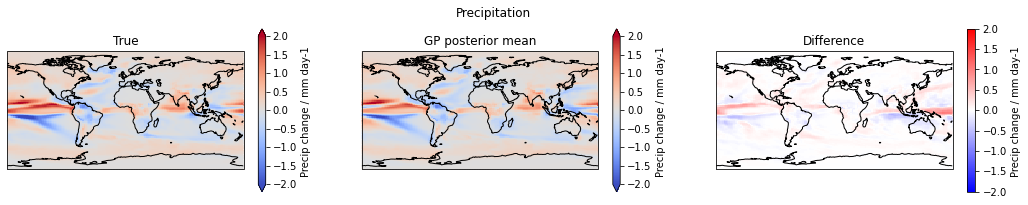

In [13]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precipitation')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Precip change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- CO2 (0.53)
- SO2 (1.21)
- Significant internal variability (0.44)

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.02724314]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.7145882135577846
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,4.945042539166876
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,6.71499423862321e-27
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,51.921554110987785
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.015351797439969062
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1.73817827, 68.33554755, 31.97624805..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.2865263825307291
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.60708786, 7.39537901, 12.7131577..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.8185540907886618


In [15]:
# Save predictions
posterior_pr_data.to_netcdf('climatebench-gp-posterior-mean-pr-test-2019-2100.nc')
posterior_pr_std_data.to_netcdf('climatebench-gp-posterior-std-pr-test-2019-2100.nc')